In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install pandas scikit-learn
!pip install pandas matplotlib


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset


In [19]:
# Load the dataset
data_path = '/content/drive/My Drive/Final-Uni-Project/Language-Identification-in-songs/Chara-Based-Model/Jupyter-Scripts/DataSets/Main_Full_Corrected_Updated_Lyrics_Training_Data (1).xlsx'

df = pd.read_excel(data_path)


df['labels'] = df['language_label'].str.split(',').apply(lambda x: [label.strip() for label in x])

# Generate unique labels and mapping
all_labels = sorted(set(label for sublist in df['labels'] for label in sublist))
label_map = {label: i for i, label in enumerate(all_labels)}

# Convert labels to multi-hot encoding
df['label_ids'] = df['labels'].apply(lambda labels: [label_map[label] for label in labels])


In [20]:
import unicodedata
import re

def normalize_text(texts):
    normalized_texts = []
    # Expanded set of punctuation to keep based on linguistic relevance
    keep_punctuation = {"'", "-", "’", ":", ",", ".", "!", "?", ";"}

    for text in texts:
        try:
            text = str(text).lower()  # Ensure text is a string and convert to lowercase
            text = ' '.join(text.split())  # Normalize whitespace to a single space

            # Retain letters, numbers, spaces, and specified punctuation, considering multilingual characters
            text = ''.join(
                char for char in text
                if unicodedata.category(char)[0] in ('L', 'N', 'Z')  # Letter, number, or space
                or char in keep_punctuation  # Expanded custom punctuation set
            )

            # Remove standalone numbers that may not contribute significantly to language identification
            text = re.sub(r'\b\d+\b', ' ', text)

            text = re.sub(r'[\.\,\!\?\;\:]+(?=[\.\,\!\?\;\:])', '', text)

            # Ensure there are no extra spaces created by the replacements above
            text = ' '.join(text.split())

            normalized_texts.append(text)
        except Exception as e:
            print(f"Error processing text: {text} with error {e}")
            normalized_texts.append("")  # Append an empty string to indicate an issue

    return normalized_texts

df['lyrics_normalized'] = normalize_text(df['lyrics'].tolist())

print(df[['lyrics', 'lyrics_normalized']].head())


                                              lyrics  \
0  I morgonens första ljus,\ndär tystnaden bryts ...   
1  В лучах заката мы встретились, не случайно,\nН...   
2  꿈속의 세계는 눈부시게 아름다워,\n현실의 벽 너머로 손을 뻗어.\n별빛 아래 속삭...   
3  En el pueblo donde nací, las calles cuentan hi...   
4  Под широким небом земли разных,\nМы встречаемс...   

                                   lyrics_normalized  
0  i morgonens första ljus, där tystnaden bryts a...  
1  в лучах заката мы встретились, не случайно, на...  
2  꿈속의 세계는 눈부시게 아름다워, 현실의 벽 너머로 손을 뻗어. 별빛 아래 속삭임,...  
3  en el pueblo donde nací, las calles cuentan hi...  
4  под широким небом земли разных, мы встречаемся...  


In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Tokenize lyrics
def tokenize_function(examples):
    return tokenizer(examples['lyrics_normalized'], padding="max_length", truncation=True)

tokenized_df = df.apply(tokenize_function, axis=1)

# labels as a list of multi-hot encoded vectors
def multi_hot_encode(ids):
    vec = np.zeros(len(label_map), dtype=np.float32)
    vec[ids] = 1.0
    return vec

df['multi_hot_labels'] = df['label_ids'].apply(multi_hot_encode)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(df['lyrics_normalized'], np.stack(df['multi_hot_labels'].values), test_size=0.2, random_state=42)

# Apply tokenization
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors="pt")


In [22]:
class LyricsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

    def __len__(self):
        return len(self.labels)


In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to 0 or 1 predictions using a sigmoid function and thresholding at 0.5
    preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).numpy()
    # Flatten both predictions and labels for metric calculations
    labels_flat = labels.flatten()
    preds_flat = preds.flatten()

    accuracy = accuracy_score(labels_flat, preds_flat)
    f1 = f1_score(labels_flat, preds_flat, average='weighted')
    precision = precision_score(labels_flat, preds_flat, average='weighted')
    recall = recall_score(labels_flat, preds_flat, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }


In [24]:
# Creating dataset instances
train_dataset = LyricsDataset(train_encodings, y_train)
test_dataset = LyricsDataset(test_encodings, y_test)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(all_labels), problem_type="multi_label_classification")

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="steps"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


# Train the model
trainer.train()



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


TrainOutput(global_step=18, training_loss=0.6676199171278212, metrics={'train_runtime': 6.582, 'train_samples_per_second': 19.599, 'train_steps_per_second': 2.735, 'total_flos': 30960425463156.0, 'train_loss': 0.6676199171278212, 'epoch': 3.0})

In [25]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.6615145206451416, 'eval_accuracy': 0.7181818181818181, 'eval_f1': 0.7568627450980393, 'eval_precision': 0.8022727272727272, 'eval_recall': 0.7181818181818181, 'eval_runtime': 0.1576, 'eval_samples_per_second': 69.812, 'eval_steps_per_second': 12.693, 'epoch': 3.0}


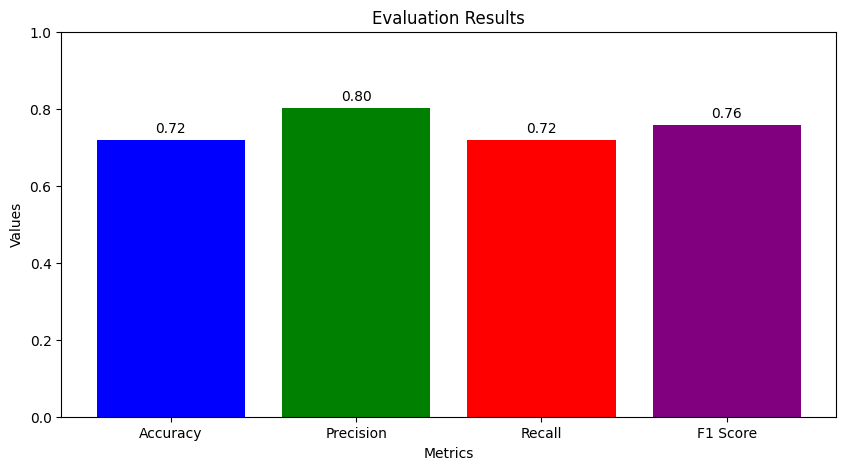

In [26]:
import matplotlib.pyplot as plt

results = trainer.evaluate()

# Metrics to plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
# Extracting the values directly from the results dictionary
values = [
    results['eval_accuracy'],
    results['eval_precision'],
    results['eval_recall'],
    results['eval_f1']
]

# Creating the bar chart
plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])

# Adding title and labels
plt.title('Evaluation Results')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1)

# Adding value labels on each bar
for i in range(len(values)):
    plt.text(i, values[i] + 0.02, f'{values[i]:.2f}', ha='center', color='black')

# Show the plot
plt.show()


In [27]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(all_labels), problem_type="multi_label_classification")
model.eval()  # Set the model to evaluation mode

def preprocess_and_predict(text):
    # Normalize and preprocess the text
    normalized_text = normalize_text([text])

    # Tokenize the text
    inputs = tokenizer(normalized_text, padding=True, truncation=True, max_length=512, return_tensors="pt")

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get probabilities using a sigmoid since it's a multi-label classification
    probs = torch.sigmoid(outputs.logits)

    # Threshold probabilities to get binary predictions
    predictions = (probs > 0.5).int()

    # Convert predicted indices to corresponding labels
    predicted_labels = [label for label, index in label_map.items() if predictions[0][index] == 1]

    return predicted_labels

# Test the function
test_text = "Bonjour, cómo estás? I hope you are doing well. مرحبا بكم في عالم متعدد اللغات."
predicted_labels = preprocess_and_predict(test_text)
print("Predicted Languages:", predicted_labels)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted Languages: ['DE', 'HI', 'RU']
